In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset from Kaggle input directory
file_path = "/kaggle/input/mergefile/Merged_Disasters(2).csv"  # Update folder name if different
df = pd.read_csv(file_path)

# Perform stratified splitting (70% Train, 15% Validation, 15% Test)
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df["Binary_class"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df["Binary_class"], random_state=42)

# Save the split datasets to Kaggle working directory
train_df.to_csv("/kaggle/working/train_data.csv", index=False)
val_df.to_csv("/kaggle/working/val_data.csv", index=False)
test_df.to_csv("/kaggle/working/test_data.csv", index=False)

# Create a structured summary table
split_summary = pd.DataFrame({
    "Train (70%)": train_df["Binary_class"].value_counts(),
    "Validation (15%)": val_df["Binary_class"].value_counts(),
    "Test (15%)": test_df["Binary_class"].value_counts(),
    "Total": df["Binary_class"].value_counts()
}).T

# Save the summary table
split_summary.to_csv("/kaggle/working/split_summary.csv")

# Display summary
print("\nData Split Summary:\n", split_summary)
print("\nData split completed and saved to the Kaggle working directory.")



Data Split Summary:
 Binary_class      Non-Damage  Damage
Train (70%)            10853    1804
Validation (15%)        2326     386
Test (15%)              2326     387
Total                  15505    2577

Data split completed and saved to the Kaggle working directory.


Loading FastText model...
Generating document embeddings...


100%|██████████| 2713/2713 [00:00<00:00, 34110.56it/s]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Original Train class distribution:
 0    10853
1     1804
Name: count, dtype: int64
Original Validation class distribution:
 0    2326
1     386
Name: count, dtype: int64
Original Test class distribution:
 0    2326
1     387
Name: count, dtype: int64
After SMOTE Train class distribution:
 1    10853
0    10853
Name: count, dtype: int64
Training CNN model...
Epoch 1/10
679/679 - 6s - 8ms/step - accuracy: 0.8281 - loss: 0.3870 - val_accuracy: 0.8219 - val_loss: 0.3702
Epoch 2/10
679/679 - 1s - 1ms/step - accuracy: 0.8709 - loss: 0.3071 - val_accuracy: 0.8544 - val_loss: 0.3322
Epoch 3/10
679/679 - 1s - 1ms/step - accuracy: 0.8875 - loss: 0.2700 - val_accuracy: 0.8739 - val_loss: 0.3114
Epoch 4/10
679/679 - 1s - 1ms/step - accuracy: 0.9068 - loss: 0.2354 - val_accuracy: 0.8477 - val_loss: 0.3810
Epoch 5/10
679/679 - 1s - 1ms/step - accuracy: 0.9150 - loss: 0.2176 - val_accuracy: 0.8573 - val_loss: 0.3627
Epoch 6/10
679/679 - 1s - 1ms/step - accuracy: 0.9236 - loss: 0.1976 - val_accuracy:

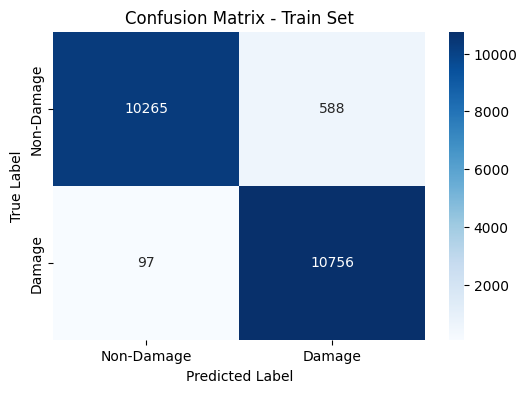

In [3]:
# ========== Imports ==========
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import gensim.downloader as api
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# ========== Load FastText Model ==========
print("Loading FastText model...")
fasttext_model = api.load("fasttext-wiki-news-subwords-300")
embedding_dim = 300

# ========== Load Data ==========
train_path = "/kaggle/working/train_data.csv"
val_path = "/kaggle/working/val_data.csv"
test_path = "/kaggle/working/test_data.csv"

train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

# ========== Clean and Map Labels ==========
label_map = {'damage': 1, 'non-damage': 0}
for df in [train_df, val_df, test_df]:
    df['Binary_class'] = df['Binary_class'].astype(str).str.strip().str.lower().map(label_map)
    df['Processed_data'] = df['Processed_data'].fillna("")

# ========== Function to Create Document Embeddings ==========
def get_avg_embedding(text, model, dim):
    words = text.split()
    embeddings = [model[word] for word in words if word in model]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(dim)

# ========== Generate Embeddings ==========
print("Generating document embeddings...")
X_train = np.vstack([get_avg_embedding(text, fasttext_model, embedding_dim) for text in tqdm(train_df['Processed_data'])])
X_val = np.vstack([get_avg_embedding(text, fasttext_model, embedding_dim) for text in tqdm(val_df['Processed_data'])])
X_test = np.vstack([get_avg_embedding(text, fasttext_model, embedding_dim) for text in tqdm(test_df['Processed_data'])])

y_train = train_df['Binary_class'].values
y_val = val_df['Binary_class'].values
y_test = test_df['Binary_class'].values

# ========== Show Class Distributions ==========
print("Original Train class distribution:\n", pd.Series(y_train).value_counts())
print("Original Validation class distribution:\n", pd.Series(y_val).value_counts())
print("Original Test class distribution:\n", pd.Series(y_test).value_counts())

# ========== Apply SMOTE ==========
smote = SMOTE(sampling_strategy=1, k_neighbors=3, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("After SMOTE Train class distribution:\n", pd.Series(y_train_smote).value_counts())

# ========== Build CNN Model ==========
model = Sequential([
    Dense(256, activation='relu', input_shape=(embedding_dim,)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# ========== Train CNN ==========
print("Training CNN model...")
history = model.fit(
    X_train_smote, y_train_smote,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=2
)

# ========== Evaluate on Train Set ==========
y_train_pred = (model.predict(X_train_smote) > 0.5).astype(int).flatten()
y_train_proba = model.predict(X_train_smote).flatten()

print("Train Classification Report:")
print(classification_report(y_train_smote, y_train_pred))
print(f'Train Accuracy: {accuracy_score(y_train_smote, y_train_pred):.4f}')
print(f'Train ROC-AUC: {roc_auc_score(y_train_smote, y_train_proba):.4f}')

# ========== Confusion Matrix - Train ==========
cm_train = confusion_matrix(y_train_smote, y_train_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Non-Damage', 'Damage'],
            yticklabels=['Non-Damage', 'Damage'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Train Set")
plt.show()
